# Analysis of MS Fredrika

Import functionality from py_fish and other libraries

In [12]:
from py_fish.operation import  speed_profile_from_data, total_consumption_from_profile, consumption_profile_from_data, extract_transit_speed
from py_fish.plotting import plot_speed_profile, plot_consumption_data, plot_profiles, plot_power_data
from py_fish.data import load_all_days, extract_low_acceleration
from py_fish.utils import FEET_PER_METRE, LITER_PER_GALLON
import matplotlib.pyplot as plt
import numpy as np

In [13]:
ENGINE_RATING = 242.0
LENGTH = 11.91
BEAM = 4

Plot speed profile of MS Fredrika a typical day of fishing

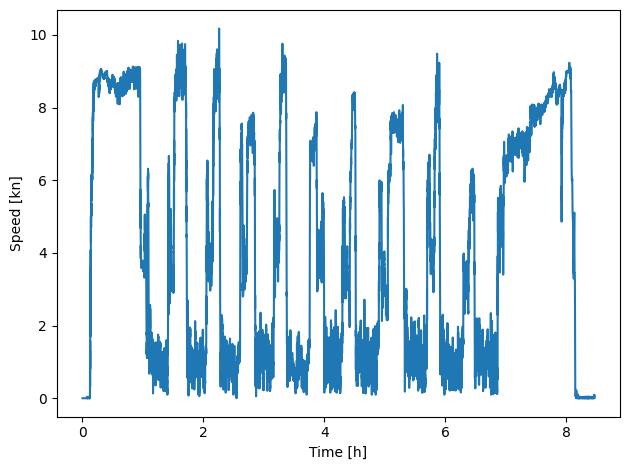

In [14]:
fig, ax = plt.subplots()
date = "2023-10-30"
plot_speed_profile(speed_profile_from_data(date), ax=ax)
fig.tight_layout()

Fit load models to consumption data

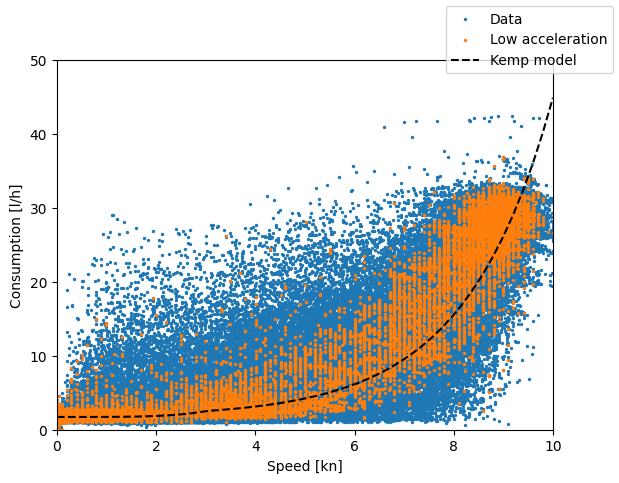

In [15]:
fig, ax = plt.subplots()
df = load_all_days()

speed_and_consumption = df.select(["speed", "consumption"]).to_numpy()
plot_consumption_data(speed_and_consumption, ax, label="Data")
low_acceleration_speed_and_consumption = extract_low_acceleration(speed_and_consumption)
plot_consumption_data(low_acceleration_speed_and_consumption, ax, label="Low acceleration")

from py_fish.engine import calculate_consumption, EngineApplication, calculate_power_from_consumption
from py_fish.loads import calculate_propulsion_power, calculate_dc_energy, calculate_hydraulics_energy

speeds = np.linspace(0,10)
powers = calculate_propulsion_power(speeds=speeds, length=LENGTH, beam=BEAM)
consumptions = calculate_consumption(powers=powers, engine_rating=ENGINE_RATING, engine_application=EngineApplication.PROPULSION)
ax.plot(speeds, consumptions, label="Kemp model", color="black", linestyle="--")
fig.legend()


Extract transit

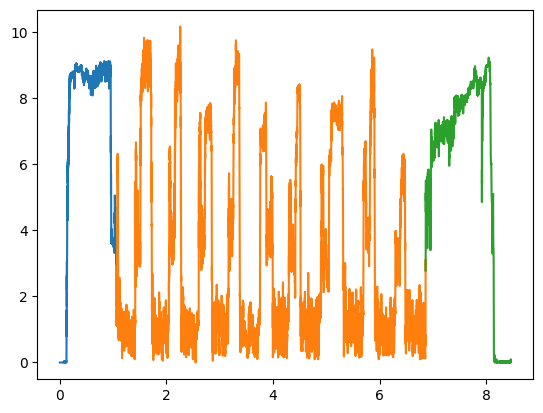

In [16]:
fix, ax = plt.subplots()
measured_speed_profile = speed_profile_from_data(date)
(transit_out, fishing, transit_in) = extract_transit_speed(measured_speed_profile)
time_fishing = fishing[-1, 0] - fishing[0, 0]
plot_profiles(ax, transit_out, fishing, transit_in)

Compare measured and approximated fuel usage

83.02805527655502 69.93873446410517


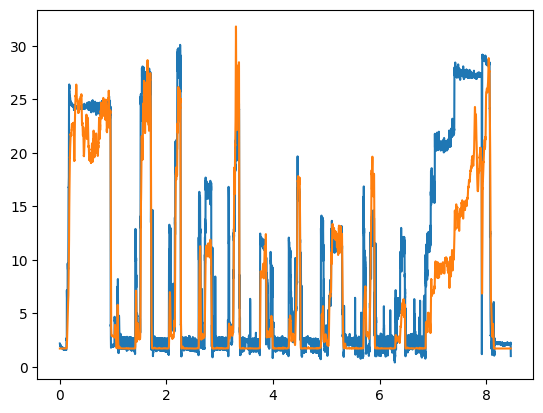

In [17]:
from scipy.ndimage import uniform_filter1d
measured_consumption_profile = consumption_profile_from_data(date) 
measured_consumption = total_consumption_from_profile(measured_consumption_profile)
model_power = calculate_propulsion_power(speeds=uniform_filter1d(measured_speed_profile[:, 1], size=30), length=LENGTH, beam=BEAM)
model_consumption_profile = np.column_stack((measured_consumption_profile[:, 0], calculate_consumption(powers=model_power, engine_rating=ENGINE_RATING, engine_application=EngineApplication.PROPULSION)))
model_consumption_propulsion = total_consumption_from_profile(model_consumption_profile)
power_hydraulics = calculate_hydraulics_energy(hours_fishing=time_fishing, hydraulic_deck_load_power=2.0)
power_dc = calculate_dc_energy(hours_total=measured_speed_profile[-1, 0] - measured_speed_profile[0,0])
hydraulics_consumption = calculate_consumption(powers=power_hydraulics, engine_rating=ENGINE_RATING, engine_application=EngineApplication.PROPULSION)
dc_consumption = calculate_consumption(powers=power_dc, engine_rating=ENGINE_RATING, engine_application=EngineApplication.PROPULSION)

fig, ax = plt.subplots()
plot_profiles(ax, measured_consumption_profile, model_consumption_profile)
print(measured_consumption, model_consumption_propulsion + hydraulics_consumption + dc_consumption)

In [18]:
from pathlib import Path
import os
data_dir = Path(os.path.abspath('')).resolve() / "py_fish" / "fredrika"
files = [f for f in data_dir.iterdir() if f.is_file()]
output = open("fredrika_consumptions.csv", "w")
output.write("date,measured,propulsion,hydraulics,dc,total\n")
output.close()
output = open("fredrika_consumptions.csv", "a")
for file in files:
    date = file.name[3:13]
    measured_speed_profile = speed_profile_from_data(date)
    (transit_out, fishing, transit_in) = extract_transit_speed(measured_speed_profile)
    time_fishing = fishing[-1, 0] - fishing[0, 0]
    measured_consumption_profile = consumption_profile_from_data(date) 
    measured_consumption = total_consumption_from_profile(measured_consumption_profile)
    model_power = calculate_propulsion_power(speeds=uniform_filter1d(measured_speed_profile[:, 1], size=30), length=LENGTH, beam=BEAM)*1.11557389
    model_consumption_profile = np.column_stack((measured_consumption_profile[:, 0], calculate_consumption(powers=model_power, engine_rating=ENGINE_RATING, engine_application=EngineApplication.PROPULSION)))
    model_consumption_propulsion = total_consumption_from_profile(model_consumption_profile)
    power_hydraulics = calculate_hydraulics_energy(hours_fishing=time_fishing, hydraulic_deck_load_power=2.0)
    power_dc = calculate_dc_energy(hours_total=measured_speed_profile[-1, 0] - measured_speed_profile[0,0])
    hydraulics_consumption = calculate_consumption(powers=power_hydraulics, engine_rating=ENGINE_RATING, engine_application=EngineApplication.PROPULSION)
    dc_consumption = calculate_consumption(powers=power_dc, engine_rating=ENGINE_RATING, engine_application=EngineApplication.PROPULSION)
    output.write(f"{date},{measured_consumption},{model_consumption_propulsion},{hydraulics_consumption},{dc_consumption},{model_consumption_propulsion + hydraulics_consumption + dc_consumption}\n")

output.close()

Assume engine model correct, transform consumption to power and fit parameters to data

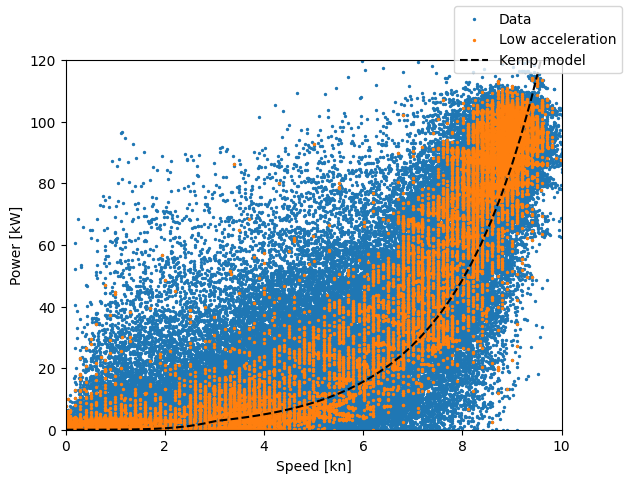

In [19]:
fig, ax = plt.subplots()
df = load_all_days()

speed_and_consumption = df.select(["speed", "consumption"]).to_numpy()
speed_and_power = np.column_stack((speed_and_consumption[:, 0], calculate_power_from_consumption(consumptions=speed_and_consumption[:, 1], engine_rating=242.0, engine_application=EngineApplication.PROPULSION)))
plot_power_data(speed_and_power, ax, label="Data")
low_acceleration_speed_and_consumption = extract_low_acceleration(speed_and_consumption)
low_acceleration_speed_and_power = np.column_stack((low_acceleration_speed_and_consumption[:, 0], calculate_power_from_consumption(consumptions=low_acceleration_speed_and_consumption[:, 1], engine_rating=ENGINE_RATING, engine_application=EngineApplication.PROPULSION)))
plot_power_data(low_acceleration_speed_and_power, ax, label="Low acceleration")

speeds = np.linspace(0,10)
powers = calculate_propulsion_power(speeds=speeds, length=LENGTH, beam=BEAM)
ax.plot(speeds, powers, label="Kemp model", color="black", linestyle="--")
fig.legend()

array([1.11557389])

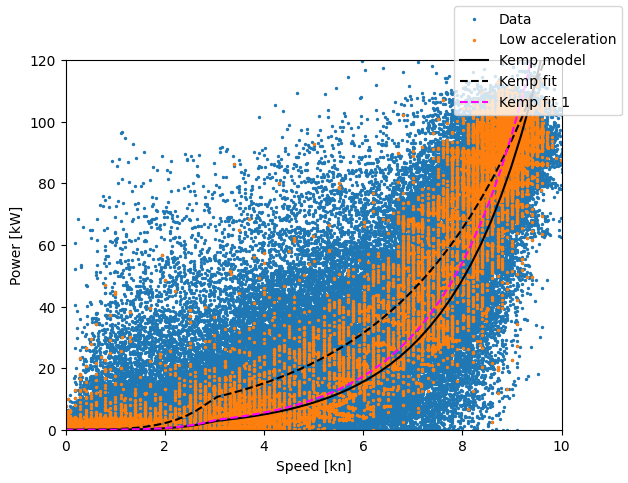

In [20]:
from scipy.optimize import curve_fit

def power(speed, c4, c14):
     return (
        np.power((np.minimum(speed, 3) / 3), 3)
        * LENGTH
        * FEET_PER_METRE
        * np.sqrt(BEAM * FEET_PER_METRE)
        * c4
        * np.exp(speed * c14)
    )

def power1(speed, c4):
     return power(speed, c4, 0.57)
popt, pcov = curve_fit(power,low_acceleration_speed_and_power[:, 0], low_acceleration_speed_and_power[:, 1])
popt1, pcov1 = curve_fit(power1,low_acceleration_speed_and_power[:, 0], low_acceleration_speed_and_power[:, 1])
fig, ax = plt.subplots()
plot_power_data(speed_and_power, ax, label="Data")
plot_power_data(low_acceleration_speed_and_power, ax, label="Low acceleration")
ax.plot(speeds, powers, label="Kemp model", color="black")
ax.plot(speeds, calculate_propulsion_power(speeds=speeds, length=LENGTH, beam=BEAM, c4=popt[0], c14=popt[1]), label="Kemp fit", color="black", linestyle="--")
ax.plot(speeds, calculate_propulsion_power(speeds=speeds, length=LENGTH, beam=BEAM, c4=popt1[0]), label="Kemp fit 1", color="magenta", linestyle="--")
fig.legend()
popt1/3.6e-3

C:\Users\arvid\AppData\Local\Temp\ipykernel_8092\411994414.py:2: RuntimeWarning: divide by zero encountered in log
  ax.scatter(speed_and_power[:, 0], np.log(speed_and_power[:, 1]),s=2, label="Data")
C:\Users\arvid\AppData\Local\Temp\ipykernel_8092\411994414.py:3: RuntimeWarning: divide by zero encountered in log
  ax.scatter(low_acceleration_speed_and_power[:, 0], np.log(low_acceleration_speed_and_power[:, 1]),s=2, label="Low acceleration")
C:\Users\arvid\AppData\Local\Temp\ipykernel_8092\411994414.py:4: RuntimeWarning: divide by zero encountered in log
  ax.plot(speeds, np.log(powers), label="Kemp model", color="black")


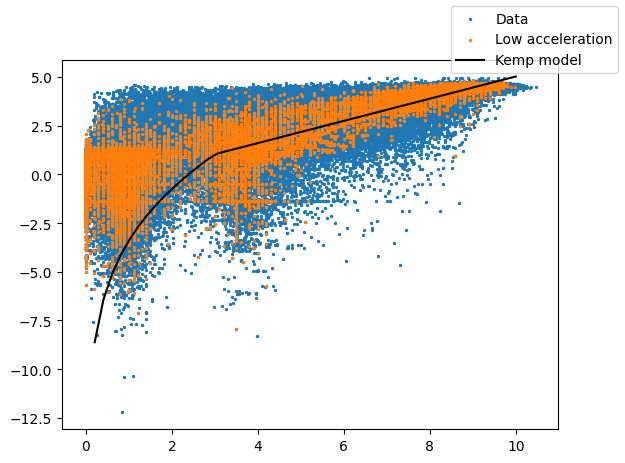

In [21]:
fig, ax = plt.subplots()
ax.scatter(speed_and_power[:, 0], np.log(speed_and_power[:, 1]),s=2, label="Data")
ax.scatter(low_acceleration_speed_and_power[:, 0], np.log(low_acceleration_speed_and_power[:, 1]),s=2, label="Low acceleration")
ax.plot(speeds, np.log(powers), label="Kemp model", color="black")
fig.legend()